In [7]:
import os
import time
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [8]:
def one_hot(x):
    return np.identity(16)[x:x+1]


In [9]:
#  init setting
tf.compat.v1.disable_eager_execution()
# plt.switch_backend('agg')

env = gym.make('FrozenLake-v0')

# Set Q-learning parameters
num_episodes = 2000
learning_rate = 0.1
dis = .99

# Input and output size based on the Env
input_size = env.observation_space.n
output_size = env.action_space.n

# These lines establish the feed-forward part of the network used to choose actions
# state input
X = tf.compat.v1.placeholder(shape=[1, input_size], dtype=tf.float32)
# weight
W = tf.Variable(tf.random.uniform([input_size, output_size], 0, 0.01))
# Y label
Y = tf.compat.v1.placeholder(shape=[1, output_size], dtype=tf.float32)
# Out Q prediction
Qpred = tf.matmul(X, W)
# optimizer
loss = tf.reduce_sum(input_tensor=tf.square(Y-Qpred))
train = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)


In [10]:
start_time = time.time()
# rewards per episode
rList = []
init = tf.compat.v1.global_variables_initializer()
with tf.compat.v1.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environment and get first new observation
        s = env.reset()
        e = 1. / ((i / 50) + 10)
        rAll = 0
        done = False
        local_loss = []

        # The Q-Table learning algorithm
        while not done:
            # Choose an action by greedly (with a chance of random action)
            # from the Q-network
            Qs = sess.run(Qpred, feed_dict={X: one_hot(s)})
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)

            # Get new state and reward from environment
            s1, reward, done, _ = env.step(a)
            if done:
                # Update Q, and no Qs+1, since it's a termial state
                Qs[0, a] = reward
            else:
                # Obtain the Q_s` values by feeding the new state through our network
                Qs1 = sess.run(Qpred, feed_dict={X: one_hot(s1)})
                # Update Q
                Qs[0, a] = reward + dis*np.max(Qs1)

            # Train our network using target (Y) and predicted Q (Qpred) values
            sess.run(train, feed_dict={X: one_hot(s), Y: Qs})

            rAll += reward
            s = s1

        rList.append(rAll)


--- 149.14279556274414 seconds ---
Success rate: 0.4295


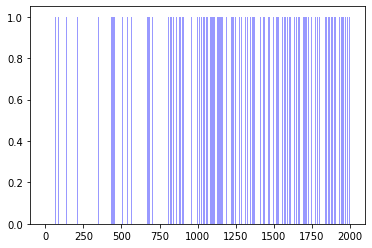

In [11]:
print("--- %s seconds ---" % (time.time() - start_time))
print("Success rate: " + str(sum(rList) / num_episodes))
plt.bar(range(len(rList)), rList, color='b', alpha=0.4)
plt.show()
